## GeekBrains / Машинное обучение в бизнесе

## Домашнее задание А.Николаев / Урок 5. Кейс 1. Аномалии и артефакты

### Задача №1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [72]:
%matplotlib inline
from datetime import date
# from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [73]:
warnings.filterwarnings('ignore')

In [74]:
def get_currenсies_er_1diff(filename, date_col, rate_col, diffs_col_name):
    df=pd.read_excel(filename, parse_dates = [date_col], usecols=[date_col, rate_col])
    date_col_name = list(df)[0]
    df.set_index(date_col_name, inplace=True)
    df.index.name = None
    df[diffs_col_name] = df.diff(periods=1).dropna()
    df[diffs_col_name][0] = 0.0
    return df

In [75]:
def adf_test(df):
    test = sm.tsa.adfuller(df)
    print(f'adf: {test[0]}')
    print(f'p-value: {test[1]}')
    print(f'Critical values: {test[4]}')
    if test[0] > test[4]['5%']:
        print('Есть единичные корни, ряд не стационарен')
        print('----------------------------------------------------------------------------------------------------')
        return False
    else:
        print('Единичных корней нет, ряд стационарен')
        print('----------------------------------------------------------------------------------------------------')
        return True

In [76]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [77]:
def add_feature(df, p):
    _df = df.copy(deep=True)
    for i in range(p):
        _df[f't{i}'] = 0
        _df.iloc[i+1:, i+1] = _df.iloc[:(i+1)*(-1), 0].values
    _df.fillna(0)
    return _df

In [78]:
df = pd.read_csv('my_BRENT2019.csv', sep = ',', index_col=[0], parse_dates=[0])
df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
Значение           2667 non-null float64
year               2667 non-null int64
month              2667 non-null int64
dayofmonth         2667 non-null int64
quarter            2667 non-null int64
dayofyear          2667 non-null int64
weekofyear         2667 non-null int64
dayofweek          2667 non-null int64
is_holiday         2667 non-null int64
is_prev_holiday    2667 non-null int64
is_next_holiday    2667 non-null int64
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


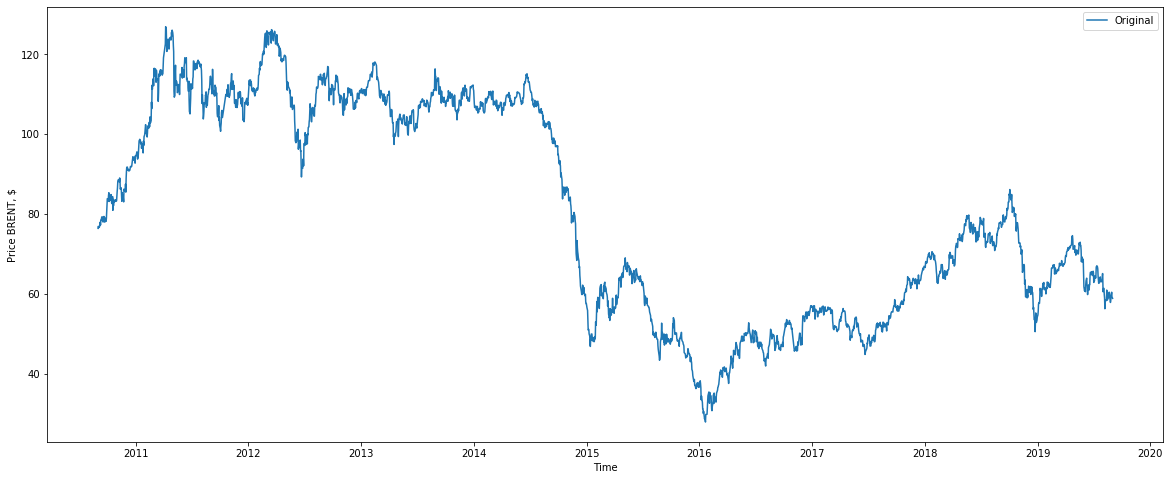

In [80]:
plt.figure(figsize=(20, 8))
plt.plot(df['Значение'], label='Original')
plt.ylabel('Price BRENT, $')
plt.xlabel('Time')
plt.legend()
plt.show()

In [81]:
# Добавляем к датафрейму признак первых разностей
df['1diff'] = df['Значение'].diff(periods=1).dropna()
df['1diff'][0] = 0.0

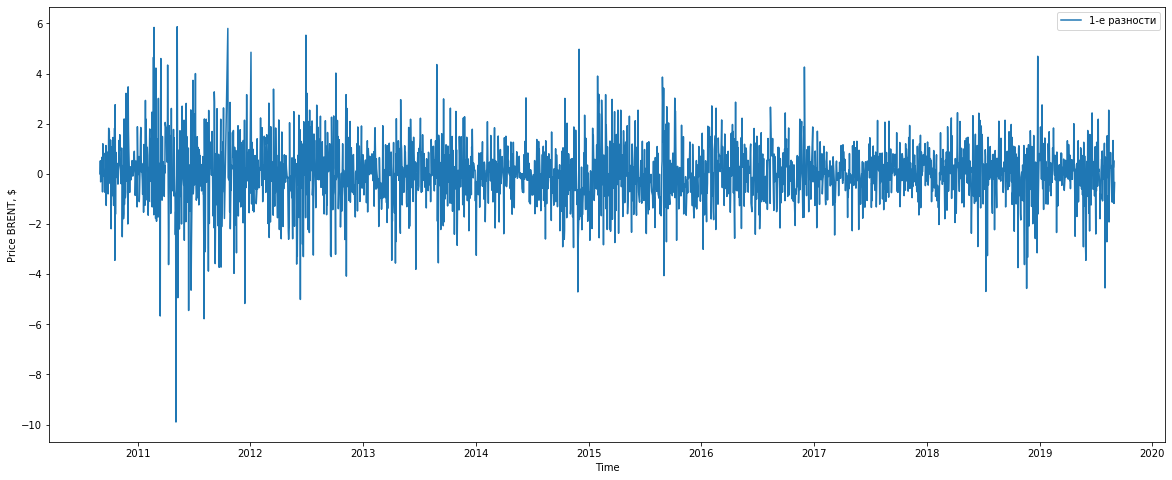

In [82]:
plt.figure(figsize=(20, 8))
plt.plot(df['1diff'], label='1-е разности')
plt.ylabel('Price BRENT, $')
plt.xlabel('Time')
plt.legend()
plt.show()

### Задача №2. Добавьте первые разности по стоимости доллара и евро к рублю сделайте ее перрасчет (ресемплинг) в представление по неделям

In [83]:
df_re = get_currenсies_er_1diff('R_E01_09_2010_T01_09_2019.xlsx', 1, 2, '1diff_euro')
df_re.head()

,curs,1diff_euro
2010-09-01,39.0127,0.0000
2010-09-02,39.1654,0.1527
2010-09-03,39.2901,0.1247
2010-09-04,39.3505,0.0604
2010-09-07,39.4720,0.1215


In [84]:
df_re.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 2 columns):
curs          2228 non-null float64
1diff_euro    2228 non-null float64
dtypes: float64(2)
memory usage: 132.2 KB


In [85]:
df_rd = get_currenсies_er_1diff('RC_F01_09_2010_T01_09_2019.xlsx', 1, 2, '1diff_dollar')
df_rd.head()

,curs,1diff_dollar
2010-09-01,30.8669,0.0000
2010-09-02,30.8001,-0.0668
2010-09-03,30.6858,-0.1143
2010-09-04,30.6922,0.0064
2010-09-07,30.5771,-0.1151


In [86]:
df_rd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 2 columns):
curs            2228 non-null float64
1diff_dollar    2228 non-null float64
dtypes: float64(2)
memory usage: 132.2 KB


In [87]:
# проверит датасеты на дубли значений по целевому признаку
print('Цена марки BRENT - ', 'дубликаты есть' if any(df.index.duplicated()) else 'дубликатов нет')
print('Курс RUR/$USA - ','дубликаты есть' if any(df_rd.index.duplicated()) else 'дубликатов нет')
print('Курс RUR/EUR - ','дубликаты есть' if any(df_re.index.duplicated()) else 'дубликатов нет')

Цена марки BRENT -  дубликатов нет
Курс RUR/$USA -  дубликатов нет
Курс RUR/EUR -  дубликатов нет


Количество значений целевого признака "Цена нефти марки BRENT" = 2667<br>
Количество значений курса рубля к долларe = 2228<br>
Количество значений курса рубля к евро = 2228<br>
Попробуем разобраться в чем причина несоотвествия.

Предположение, что курс не всегда добавлялся в датасет (например в выходные). Найдем пропуски по дням.

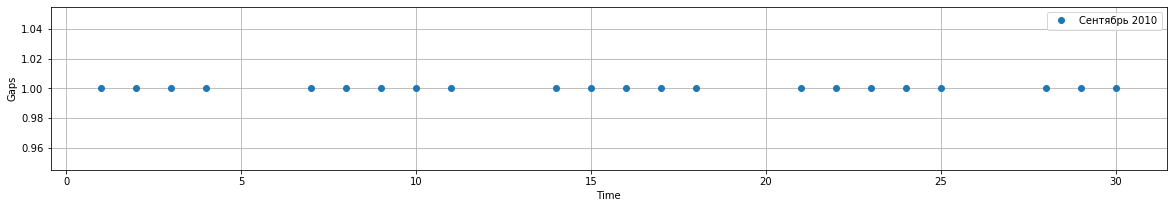

In [88]:
# построим график курса за месяц
df_rd_092010 = df_rd['2010-09-01':'2010-09-30']['curs'].index.day
plt.figure(figsize=(20, 3))
plt.plot(df_rd_092010.value_counts().index, df_rd_092010.value_counts().values, 'o', label='Сентябрь 2010')
plt.ylabel('Gaps')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

##### Как видим, в выходные курсы валют не проставлялись.

In [89]:
# заполним пропущенные даты предыдущими значениями курса
dates_rd_full = pd.date_range(df_rd.index.min(), df_rd.index.max(), freq="D")
df_rd_full = pd.DataFrame(dates_rd_full, columns=['date'], index=dates_rd_full)
df_rd_full = df_rd_full.join(df_rd, on='date', how='left')
df_rd_full.fillna(method='pad', inplace=True)
df_rd_full.head(7)

,date,curs,1diff_dollar
2010-09-01,2010-09-01,30.8669,0.0000
2010-09-02,2010-09-02,30.8001,-0.0668
2010-09-03,2010-09-03,30.6858,-0.1143
2010-09-04,2010-09-04,30.6922,0.0064
2010-09-05,2010-09-05,30.6922,0.0064
2010-09-06,2010-09-06,30.6922,0.0064
2010-09-07,2010-09-07,30.5771,-0.1151


In [90]:
df_rd_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2010-09-01 to 2019-08-31
Freq: D
Data columns (total 3 columns):
date            3287 non-null datetime64[ns]
curs            3287 non-null float64
1diff_dollar    3287 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 102.7 KB


In [91]:
dates_re_full = pd.date_range(df_re.index.min(), df_re.index.max(), freq="D")
df_re_full = pd.DataFrame(dates_re_full, columns=['date'], index=dates_re_full)
df_re_full = df_re_full.join(df_re, on='date', how='left')
df_re_full.fillna(method='pad', inplace=True)
df_re_full.head(7)

,date,curs,1diff_euro
2010-09-01,2010-09-01,39.0127,0.0000
2010-09-02,2010-09-02,39.1654,0.1527
2010-09-03,2010-09-03,39.2901,0.1247
2010-09-04,2010-09-04,39.3505,0.0604
2010-09-05,2010-09-05,39.3505,0.0604
2010-09-06,2010-09-06,39.3505,0.0604
2010-09-07,2010-09-07,39.4720,0.1215


In [92]:
df_re_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2010-09-01 to 2019-08-31
Freq: D
Data columns (total 3 columns):
date          3287 non-null datetime64[ns]
curs          3287 non-null float64
1diff_euro    3287 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 102.7 KB


In [93]:
# Объеденим датафрейм цены нефти марки BRENT и курсов
df = df.merge(df_rd_full, left_index=True, right_index=True)
df = df.merge(df_re_full, left_index=True, right_index=True)
df.index.name = 'Date'
df.head(10)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,1diff,date_x,curs_x,1diff_dollar,date_y,curs_y,1diff_euro
Date,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,2010-09-01,30.8669,0.0000,2010-09-01,39.0127,0.0000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,2010-09-02,30.8001,-0.0668,2010-09-02,39.1654,0.1527
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,2010-09-03,30.6858,-0.1143,2010-09-03,39.2901,0.1247
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,2010-09-04,30.6922,0.0064,2010-09-04,39.3505,0.0604
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01,2010-09-05,30.6922,0.0064,2010-09-05,39.3505,0.0604
2010-09-06,76.87,2010,9,6,3,249,36,0,1,0,0,0.24,2010-09-06,30.6922,0.0064,2010-09-06,39.3505,0.0604
2010-09-07,77.26,2010,9,7,3,250,36,1,0,0,1,0.39,2010-09-07,30.5771,-0.1151,2010-09-07,39.4720,0.1215
2010-09-08,77.93,2010,9,8,3,251,36,2,0,0,0,0.67,2010-09-08,30.7319,0.1548,2010-09-08,39.3215,-0.1505
2010-09-09,77.21,2010,9,9,3,252,36,3,0,0,0,-0.72,2010-09-09,30.8873,0.1554,2010-09-09,39.2948,-0.0267


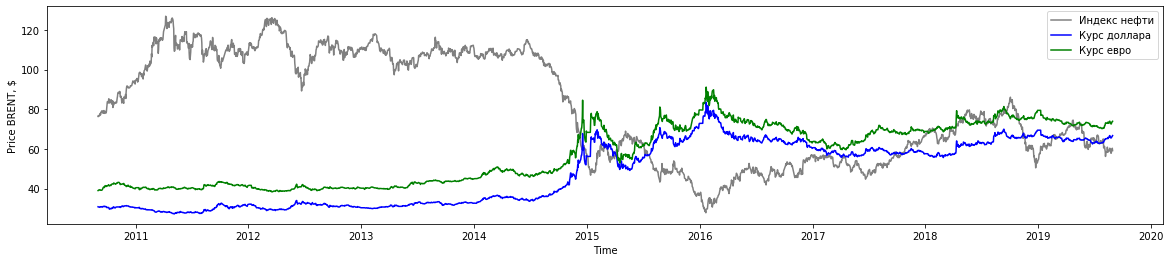

In [94]:
plt.figure(figsize =(20,4))
plt.plot(df['Значение'], color='gray', label='Индекс нефти')
plt.plot(df['curs_x'], color='blue', label='Курс доллара')
plt.plot(df['curs_y'], color='green', label='Курс евро')
plt.ylabel('Price BRENT, $')
plt.xlabel('Time')
plt.legend()
plt.show()

In [95]:
# удалим ненужные признаки из датафрейма
df.drop(columns=['year', 'month', 'dayofmonth', 'quarter', 'dayofyear', 'weekofyear', 'dayofweek', 'is_holiday',
                 'is_prev_holiday', 'is_next_holiday', 'date_x', 'curs_x', 'date_y', 'curs_y'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2666 entries, 2010-09-01 to 2019-08-30
Data columns (total 4 columns):
Значение        2666 non-null float64
1diff           2666 non-null float64
1diff_dollar    2666 non-null float64
1diff_euro      2666 non-null float64
dtypes: float64(4)
memory usage: 104.1 KB


In [96]:
df.head()

,Значение,1diff,1diff_dollar,1diff_euro
Date,,,,
2010-09-01,76.37,0.00,0.0000,0.0000
2010-09-02,76.89,0.52,-0.0668,0.1527
2010-09-03,76.57,-0.32,-0.1143,0.1247
2010-09-04,76.62,0.05,0.0064,0.0604
2010-09-05,76.63,0.01,0.0064,0.0604


In [97]:
# произведем перерасчет данных в представлении по неделям
df_week = df.resample('W').mean()
df_week.drop(columns=['Значение'], axis=1, inplace=True)
df_week.shape

(470, 3)

In [98]:
# еще раз проверим на пропуски
df_week.isnull().sum()

1diff           1
1diff_dollar    1
1diff_euro      1
dtype: int64

In [99]:
# т.к. пропуск всего один, просто удалим его
df_week = df_week.dropna()
df_week.shape

(469, 3)

In [100]:
df_week.head()

,1diff,1diff_dollar,1diff_euro
Date,,,
2010-09-05,0.052000,-0.033660,0.079640
2010-09-12,0.288333,0.034650,-0.016400
2010-09-19,-0.021667,0.033750,0.270783
2010-09-26,0.118333,-0.012383,0.157217
2010-10-03,0.791667,-0.082283,0.020433


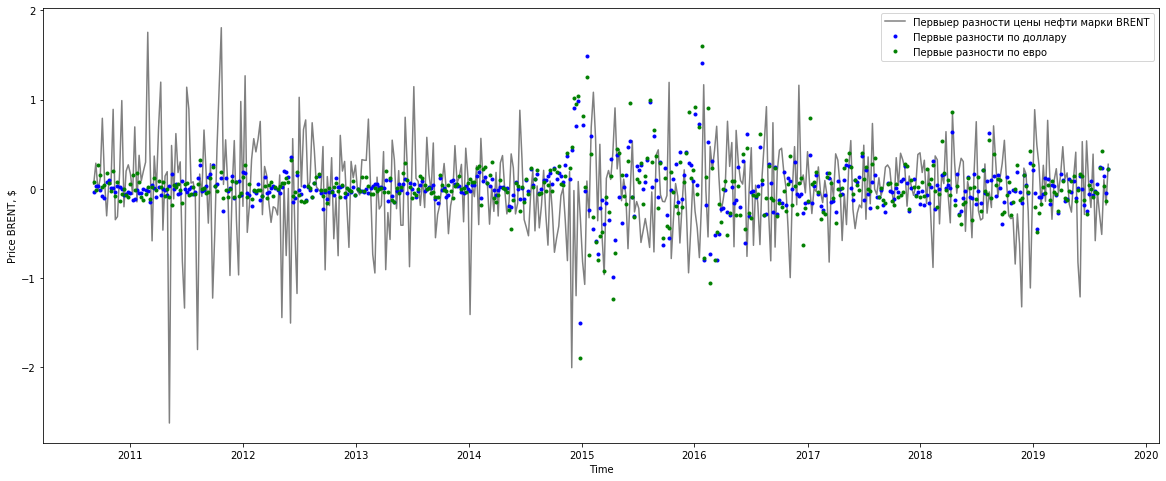

In [101]:
plt.figure(figsize=(20, 8))
plt.plot(df_week['1diff'], color='gray', label='Первыер разности цены нефти марки BRENT')
plt.plot(df_week['1diff_dollar'], '.', color='blue', label='Первые разности по доллару')
plt.plot(df_week['1diff_euro'], '.', color='green', label='Первые разности по евро')
plt.ylabel('Price BRENT, $')
plt.xlabel('Time')
plt.legend()
plt.show()

### Задача №3. Постройте модель предсказания 1-й точки от текущей (h=1)

In [102]:
# первым делом проверим первые разности на стационарность, используя обобщенный тест Дикки-Фуллера
_ = adf_test(df_week['1diff'])
_ = adf_test(df_week['1diff_dollar'])
_ = adf_test(df_week['1diff_euro'])

adf: -21.086063180837883
p-value: 0.0
Critical values: {'1%': -3.4444002781824477, '5%': -2.867735576537528, '10%': -2.57007000456571}
Единичных корней нет, ряд стационарен
----------------------------------------------------------------------------------------------------
adf: -12.64135055079296
p-value: 1.4326509334542882e-23
Critical values: {'1%': -3.4444305322234365, '5%': -2.8677488864580885, '10%': -2.5700770984781443}
Единичных корней нет, ряд стационарен
----------------------------------------------------------------------------------------------------
adf: -7.994720129435097
p-value: 2.4214504634746694e-12
Critical values: {'1%': -3.4447721346720885, '5%': -2.8678991615065095, '10%': -2.570157193174823}
Единичных корней нет, ряд стационарен
----------------------------------------------------------------------------------------------------


##### Ряды стационарны, можем строить модель.

In [103]:
# Построим признаки для нашей будущем модели. Добавим историю на глубину 5-х измерений от текущего (р=3)
p=3
df_week = add_feature(df_week, p)
df_week.head()

,1diff,1diff_dollar,1diff_euro,t0,t1,t2
Date,,,,,,
2010-09-05,0.052000,-0.033660,0.079640,0.000000,0,0
2010-09-12,0.288333,0.052000,-0.016400,0.000000,0,0
2010-09-19,-0.021667,0.288333,0.052000,0.000000,0,0
2010-09-26,0.118333,-0.021667,0.288333,0.052000,0,0
2010-10-03,0.791667,0.118333,-0.021667,0.288333,0,0


In [104]:
def split_data(df, split_date):
    return df.iloc[:split_date,:].copy(), df.iloc[split_date:,:].copy()

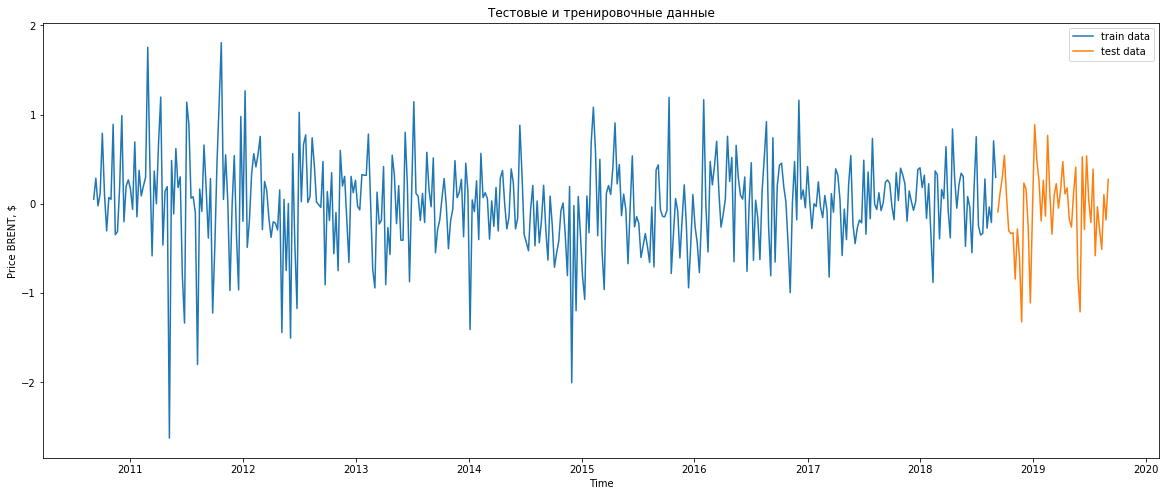

In [113]:
# разобьем данные не train и test.
train, test = split_data(df_week, -52)
plt.figure(figsize=(20, 8))
plt.plot(train.index,train.iloc[:,0], label='train data')
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.ylabel('Price BRENT, $')
plt.xlabel('Time')
plt.legend()
plt.show()

In [114]:
# глубина прогноза h=1
h=1
X_train = train.iloc[:-h,:]
y_train = train['1diff'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['1diff'].values[h:]

In [115]:
model_gbr = GradientBoostingRegressor(max_depth=15, random_state=42, n_estimators=100)
model_gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [116]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [117]:
y_train_pred_gbr = model_gbr.predict(X_train)
y_test_pred_gbr = model_gbr.predict(X_test)
y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

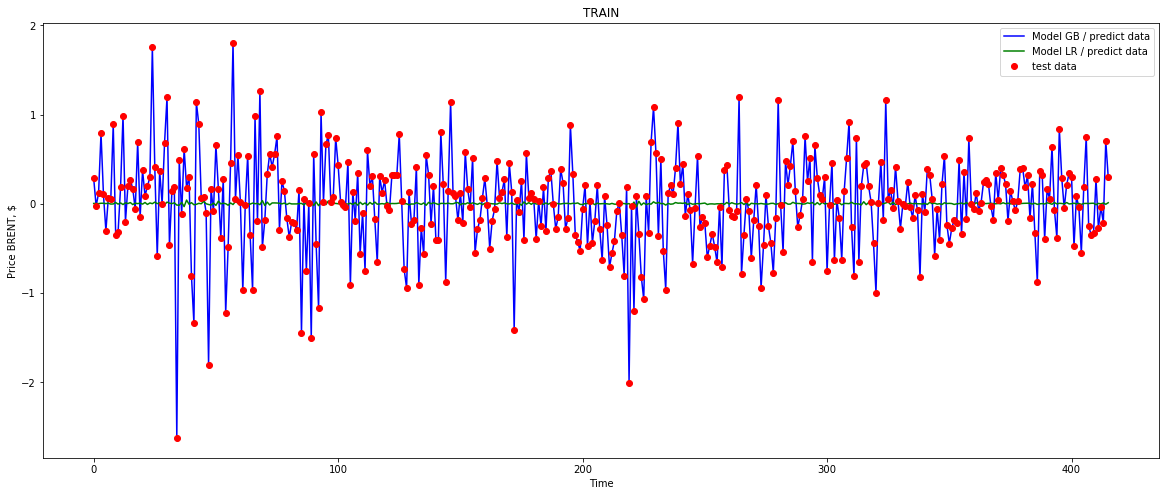

In [127]:
plt.figure(figsize=(20, 8))
plt.plot(y_train_pred_gbr, color='blue', label='Model GB / predict data')
plt.plot(y_train_pred_lr, color='green', label='Model LR / predict data')
plt.plot(y_train, 'o', color='red', label='test data')
plt.title('TRAIN')
plt.ylabel('Price BRENT, $')
plt.xlabel('Time')
plt.legend()
plt.show()

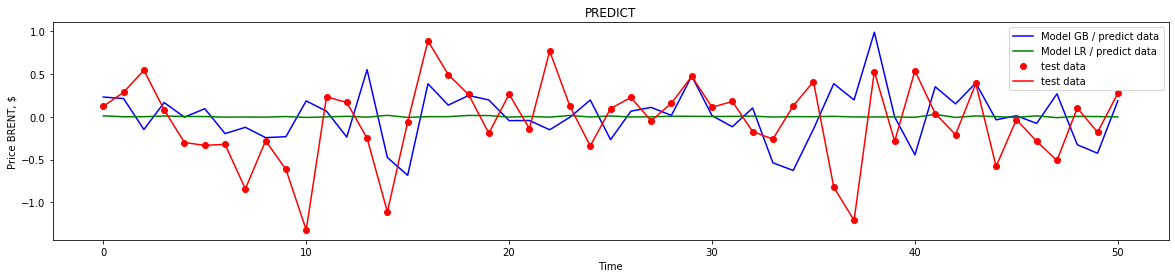

In [126]:
plt.figure(figsize=(20, 4))
plt.plot(y_test_pred_gbr, color='blue', label='Model GB / predict data')
plt.plot(y_test_pred_lr, color='green', label='Model LR / predict data')
plt.plot(y_test, 'o', color='red', label='test data')
plt.plot(y_test, color='red', label='test data')
plt.title('PREDICT')
plt.ylabel('Price BRENT, $')
plt.xlabel('Time')
plt.legend()
plt.show()

In [129]:
error = mean_absolute_percentage_error(y_test, y_test_pred_gbr)
print(f'Ошибка предсказания модели GradientBoostingRegressor (MAPE) на основе первых разностей: {error}%')

Ошибка предсказания модели GradientBoostingRegressor (MAPE) на основе первых разностей: 162.84734044319202%


### Задача №4. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

### Выводы: при переводе данных в первые разности, ошибка возрастает на порядки, что является неприемлемым. Строить модель основываясь только на первых разностях данных нельзя, предсказание будет абсолютно неверным.